# Naive Bayes

The purpose of this notebook is to read in the [UCI mushroom dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom) and apply Naive Bayes Classification.

* Learn about Naive Bayes and include the basic principles in Markdown
* Import dataset both locally and directly from the web
* Make a few simple plots looking at the dataset


In [23]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

In [2]:
# Read in data. it's comma-separated with no column names.
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
# Save file locally
# urlretrieve(url, "agaricus-lepiota.data")
df = pd.read_csv('agaricus-lepiota.data', sep=',', header=None)

#manually add column names from documentation (1st col is class: e=edible,p=poisonous; rest are attributes)
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
             'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
             'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
             'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']

In [3]:
print(df.head())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surf-below-ring  \
0            c         n          k   ...                       s   
1            c         b          k   ...                       s   
2            c         b          n   ...                       s   
3            c         n          n   ...                       s   
4            w         b          k   ...                       s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

e    4208
p    3916
Name: class, dtype: int64


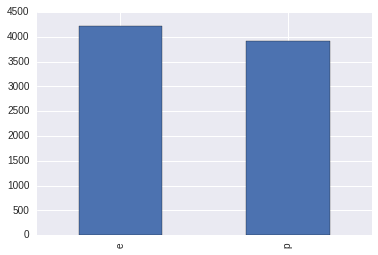

In [4]:
#show plots in notebook
%matplotlib inline

#bar chart of classes using pandas plotting
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='bar')

This plot shows the number of edible mushrroms in the dataset against the number of poisonous mushrooms. There are slightly more edible mushrooms than poisonous ones but they are fairly evenly split.  Now I will visually inspect the features for any predictive/non-predicitive features. 

w    2388
n    1968
k    1872
h    1632
r      72
y      48
u      48
o      48
b      48
Name: spore-color, dtype: int64


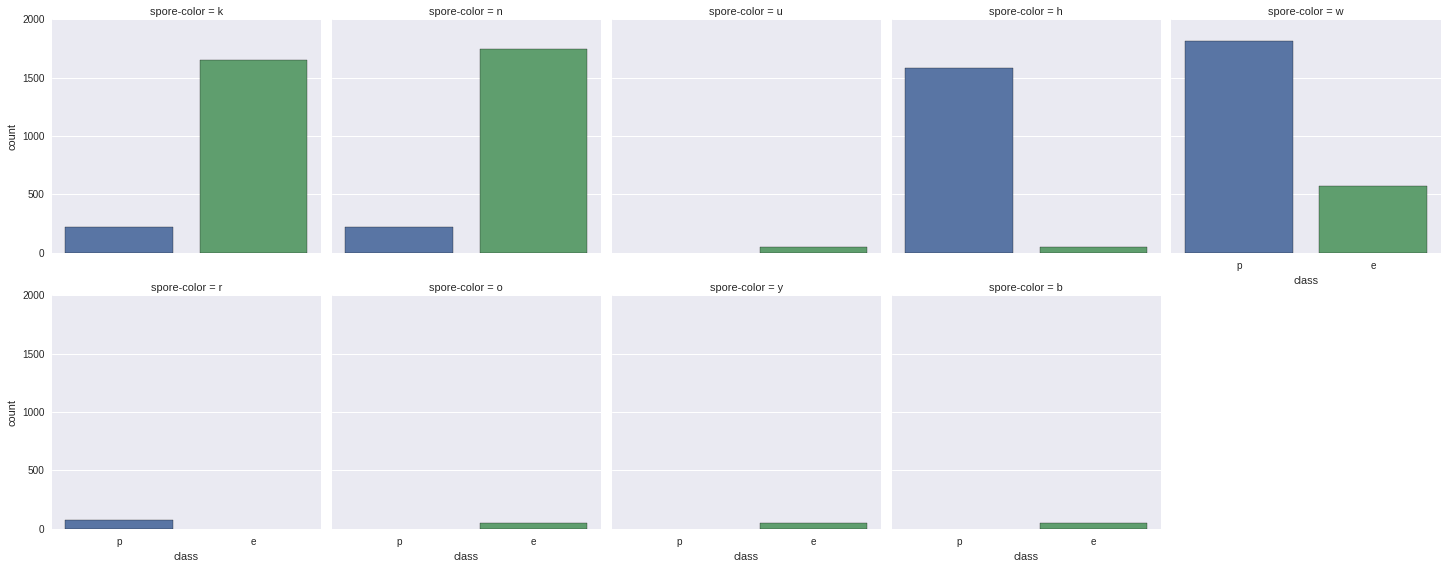

In [5]:
print(df['spore-color'].value_counts())

#seaborn factorplot to show edible/poisonous breakdown by different factors
#df_forplot = df.loc[:,('class','cap-shape','gill-color')]
#g = sns.factorplot("class", col="cap-shape", data=df_forplot,
 #                   kind="count", size=2.5, aspect=.8, col_wrap=6)

sns.factorplot("class", col = "spore-color", data = df, kind = "count", col_wrap = 5)    

Spore colour seems to be a strong indicator of poisonous/edible.

As Naive Bayes can deal with non-informatative features, first we will apply Naive Bayes to the whole feature space and look at the results. 

In [6]:
df.columns
X = df.drop('class', 1)
Y = df["class"]


As the features are all catergorical we first use preprocessing.labelencoder to convert to numeric. 

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(Y)
print(le.classes_)
y = le.transform(Y)
# Now y is an array of boolean values with poison = 1.
# Lets do the same thing for the X array

# Initialise data frame. I feel this section could be done in a more efficient way.
# Looping over columns and expanding the array x feels redundant.
x = pd.DataFrame(X, columns=[X.columns[0]])
for colname in X.columns:
    le.fit(X[colname])
   # print(colname, le.classes_)
    x[colname] = le.transform(X[colname])


['e' 'p']


In [8]:
# Now we split the dataset into training and testing. 

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
print(X_train.shape)
print(X_test.shape)


(4874, 22)
(3250, 22)


In [9]:
# Finally we apply Gaussian Naive Bayes.

#initialize and fit the naive bayes classifier
from sklearn.naive_bayes import GaussianNB
skgnb = GaussianNB()
skgnb.fit(X_train,y_train)
train_predict = skgnb.predict(X_train)
print(train_predict)
print(train_predict.shape)


[1 0 0 ..., 0 1 0]
(4874,)


Now I'll compare the train_predict with the actual results y_train using a cofusion matrix. 

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, train_predict)


array([[2290,  219],
       [ 171, 2194]])

Next, I'll use the trained Naive Bayes on the test data and look at the results. 

In [21]:
test_predict = skgnb.predict(X_test)

test_matrix = confusion_matrix(y_test, test_predict)

print(test_matrix)

print(sum(y_test==0))
print(sum(y_test==1))
print(sum(test_predict==0))
print(sum(test_predict==1))

[[1525  174]
 [ 122 1429]]
1699
1551
1647
1603


So, what have we learned? It's not clear from the array which column relates to edible and which related to poisonous. 
In the case of poisonous mushrooms we care about false positives and false negatives!

Initally we encoded edible = 0, poisonous = 1. 

Rows sum to give y_test
Columns sum to give test_predict. 

Therefore:

* 1525 edible identified as edible
* 174 edible identified as poisonous
* 122 poisonous identified as edible
* 1429 poisonous identified as poisonous

I plotted this using some code from the [sklearn help files](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) and using seaborn heatmap function.

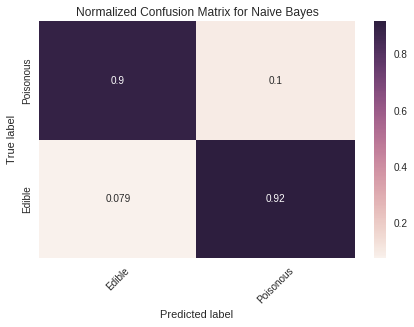

In [82]:
normalized_matrix = test_matrix.astype('float') / test_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_matrix.round(3), annot = True)

classes = ["Edible", "Poisonous"]

# Add title and x, y axis labels
plt.title("Normalized Confusion Matrix for Naive Bayes")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classes)) + 0.5
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.show()


Note that 122 mushrooms are classified as edible when they are actually poisonous! This results in a bad outcome for the human. In order to combat this, we could extract the posterior probabilities instead of the classifications and then we could use a higher threshold for classfication.

([array([ 1432.,    34.,    44.,    54.,    39.,    61.,    80.,   105.,
           201.,  1200.]),
  array([ 1200.,   201.,   105.,    80.,    61.,    39.,    54.,    44.,
            34.,  1432.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

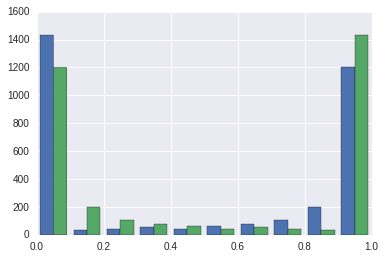

In [96]:
y_prob = skgnb.predict_proba(X_test)
plt.hist(y_prob)